In [ ]:
# ── Mount Drive (Colab) ─────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

# ── Paths (edit if your folder name differs) ───────────────────────────────────
ROOT = "/content/drive/MyDrive/celeba_dataset"
SRC_DIR = f"{ROOT}/Celebrity Image Subsets"    # contains images__<ID>_ folders
COMP_ROOT = f"{ROOT}/CompositeDataset"         # will be created

IMAGES_DIR = f"{COMP_ROOT}/images"
LABELS_DIR = f"{COMP_ROOT}/labels"
META_DIR   = f"{COMP_ROOT}/meta"

# ── Create folders ─────────────────────────────────────────────────────────────
import os, shutil, random, json, math, glob
from pathlib import Path

for p in [COMP_ROOT, IMAGES_DIR, LABELS_DIR, META_DIR]:
    os.makedirs(p, exist_ok=True)
for split in ["train","val","test"]:
    os.makedirs(f"{IMAGES_DIR}/{split}", exist_ok=True)
    os.makedirs(f"{LABELS_DIR}/{split}", exist_ok=True)

# ── Install deps ───────────────────────────────────────────────────────────────
!pip -q install ultralytics==8.3.34 opencv-python pillow numpy tqdm

import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from tqdm.auto import tqdm
random.seed(42)
np.random.seed(42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ── Parse celeb IDs from folder names images__<ID>_ ────────────────────────────
folders = sorted([p for p in glob.glob(f"{SRC_DIR}/images__*_") if os.path.isdir(p)])
def parse_id(path):
    # expects .../images__<ID>_/
    base = os.path.basename(path.strip("/"))
    # split on double underscores and trailing underscore
    try:
        return base.split("__")[1].rstrip("_")
    except Exception:
        return None

raw_ids = [parse_id(p) for p in folders]
celeb_ids = [cid for cid in raw_ids if cid is not None]
assert len(celeb_ids) >= 2, "No celebrity folders found. Check naming pattern."

# Ensure unique & stable order (sorted as strings keeps IDs like 3401 intact)
celeb_ids = sorted(list(set(celeb_ids)), key=lambda x: int(x))
num_classes = len(celeb_ids)
print(f"Found {num_classes} celebrity IDs.")

# ── Build id_map.csv (idx → celeb_id) ─────────────────────────────────────────
import csv
with open(f"{META_DIR}/id_map.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["idx","celeb_id"])
    for idx, cid in enumerate(celeb_ids):
        writer.writerow([idx, cid])

# Helper: map celeb_id -> class_idx
id_to_idx = {cid: i for i, cid in enumerate(celeb_ids)}


Found 45 celebrity IDs.


In [ ]:

GRID_ROWS, GRID_COLS = 4, 4     # 4×4 grid (16 cells)
CANVAS = (1024, 1024)           # larger image so faces stay visible
CELL_W = CANVAS[0] // GRID_COLS
CELL_H = CANVAS[1] // GRID_ROWS
GUTTER = 8                      # slightly smaller gaps

N_BASE = 1600
SPLIT_COUNTS = {"train": 1120, "val": 240, "test": 240}


# Gather image lists per celeb_id
id_to_images = {}
valid_exts = {".jpg",".jpeg",".png",".bmp"}
for cid in celeb_ids:
    folder = f"{SRC_DIR}/images__{cid}_"
    imgs = []
    for ext in valid_exts:
        imgs.extend(glob.glob(f"{folder}/**/*{ext}", recursive=True))
    imgs = [p for p in imgs if os.path.isfile(p)]
    if len(imgs) == 0:
        print(f"Warning: no images for celeb {cid}")
    id_to_images[cid] = imgs

# Round-robin sampler to keep balance across 45 celebs
from itertools import cycle
rr_ids = []
repeat = math.ceil((N_BASE * GRID_ROWS * GRID_COLS) / len(celeb_ids))  # total slots / num IDs
balanced_list = celeb_ids * repeat
random.shuffle(balanced_list)
rr = cycle(balanced_list)


In [ ]:
def fit_within(img: Image.Image, cell_w, cell_h, keep_aspect=True):
    """Resize PIL image to fit within cell while keeping aspect; returns resized image."""
    if keep_aspect:
        img = img.copy()
        img.thumbnail((cell_w - GUTTER, cell_h - GUTTER), Image.LANCZOS)
        return img
    else:
        return img.resize((cell_w - GUTTER, cell_h - GUTTER), Image.LANCZOS)

def cell_origin(col, row, cell_w, cell_h, gutter=0):
    x0 = col*cell_w + gutter//2
    y0 = row*cell_h + gutter//2
    return x0, y0

def paste_center(canvas: Image.Image, tile: Image.Image, x0, y0, cell_w, cell_h):
    """Paste tile centered within the cell at (x0,y0). Returns (xmin,ymin,xmax,ymax) on canvas."""
    tw, th = tile.size
    cx = x0 + cell_w//2
    cy = y0 + cell_h//2
    xmin = int(cx - tw//2)
    ymin = int(cy - th//2)
    xmin = max(xmin, x0)
    ymin = max(ymin, y0)
    xmax = min(xmin + tw, x0 + cell_w - 1)
    ymax = min(ymin + th, y0 + cell_h - 1)
    canvas.paste(tile, (xmin, ymin))
    return xmin, ymin, xmax, ymax

def xyxy_to_yolo(xmin, ymin, xmax, ymax, W, H):
    w = max(1, xmax - xmin + 1)
    h = max(1, ymax - ymin + 1)
    cx = xmin + w/2
    cy = ymin + h/2
    return cx/W, cy/H, w/W, h/H

def rand_pick_image(cid):
    imgs = id_to_images.get(cid, [])
    if not imgs:
        return None
    return random.choice(imgs)


In [ ]:
def next_n_distinct(rr_iter, pool, n):
    """Return n distinct celeb IDs with available images."""
    chosen = set()
    attempt = 0
    while len(chosen) < n and attempt < 2000:
        c = next(rr_iter)
        if c in pool and id_to_images.get(c):
            chosen.add(c)
        attempt += 1
    return list(chosen)

counter = {"train": 0, "val": 0, "test": 0}
index = 0

for split in ["train", "val", "test"]:
    target = SPLIT_COUNTS[split]
    pbar = tqdm(total=target, desc=f"Building {split} composites")
    built = 0
    while built < target:
        # choose distinct celeb IDs for a 4x4 grid (16 total)
        num_needed = GRID_ROWS * GRID_COLS   # = 16 if 4x4
        cids = next_n_distinct(rr, celeb_ids, num_needed)
        if len(cids) < num_needed:
            print(f"Warning: Only found {len(cids)} distinct celeb IDs for a {GRID_ROWS}x{GRID_COLS} grid. Skipping.")
            continue

        canvas = Image.new("RGB", CANVAS, (245, 245, 245))
        labels = []
        ok = True
        used = set()

        # place tiles row-major
        for r in range(GRID_ROWS):
            for c in range(GRID_COLS):
                cid = cids[r * GRID_COLS + c]
                if cid in used:
                    ok = False
                    break
                used.add(cid)

                src_path = rand_pick_image(cid)
                if src_path is None:
                    ok = False
                    break

                try:
                    tile = Image.open(src_path).convert("RGB")
                except:
                    ok = False
                    break

                tile = fit_within(tile, CELL_W, CELL_H, keep_aspect=True)
                x0, y0 = cell_origin(c, r, CELL_W, CELL_H, GUTTER)
                xmin, ymin, xmax, ymax = paste_center(canvas, tile, x0, y0, CELL_W, CELL_H)
                cx, cy, w, h = xyxy_to_yolo(xmin, ymin, xmax, ymax, CANVAS[0], CANVAS[1])

                class_idx = id_to_idx[cid]
                labels.append((class_idx, cx, cy, w, h))
            if not ok:
                break

        # skip if image incomplete
        if not ok or len(labels) != num_needed:
            continue

        stem = f"comp_{index:06d}"
        img_out = f"{IMAGES_DIR}/{split}/{stem}.jpg"
        lab_out = f"{LABELS_DIR}/{split}/{stem}.txt"

        canvas.save(img_out, quality=92)
        with open(lab_out, "w") as f:
            for cls, cx, cy, w, h in labels:
                f.write(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

        built += 1
        index += 1
        pbar.update(1)
    pbar.close()


Building train composites:   0%|          | 0/1120 [00:00<?, ?it/s]

In [ ]:
AUG_TRAIN = True

def augment_photometric(pil_img):
    # mild brightness & contrast jitter, occasional blur
    br = ImageEnhance.Brightness(pil_img).enhance( np.random.uniform(0.9, 1.1) )
    ct = ImageEnhance.Contrast(br).enhance( np.random.uniform(0.9, 1.1) )
    if np.random.rand() < 0.25:
        ct = ct.filter(ImageFilter.GaussianBlur(radius=np.random.uniform(0.2, 0.8)))
    return ct

def flip_labels_horiz(yolo_lines):
    out = []
    for line in yolo_lines:
        cls, cx, cy, w, h = line
        cx_flipped = 1.0 - cx
        out.append((cls, cx_flipped, cy, w, h))
    return out

if AUG_TRAIN:
    train_imgs = sorted(glob.glob(f"{IMAGES_DIR}/train/*.jpg"))
    for img_path in tqdm(train_imgs, desc="Augmenting train (+1x)"):
        stem = Path(img_path).stem
        lab_path = f"{LABELS_DIR}/train/{stem}.txt"
        if not os.path.exists(lab_path):
            continue

        # read labels
        yolo_lines = []
        with open(lab_path, "r") as f:
            for ln in f:
                toks = ln.strip().split()
                cls = int(toks[0]); cx,cy,w,h = map(float, toks[1:5])
                yolo_lines.append((cls,cx,cy,w,h))

        # 50% flip horizontally
        img = Image.open(img_path).convert("RGB")
        do_flip = np.random.rand() < 0.5
        if do_flip:
            img_aug = img.transpose(Image.FLIP_LEFT_RIGHT)
            labels_aug = flip_labels_horiz(yolo_lines)
        else:
            img_aug = img.copy()
            labels_aug = yolo_lines

        # photometric
        img_aug = augment_photometric(img_aug)

        # save with new stem
        new_stem = stem + "_aug1"
        img_out = f"{IMAGES_DIR}/train/{new_stem}.jpg"
        lab_out = f"{LABELS_DIR}/train/{new_stem}.txt"

        img_aug.save(img_out, quality=92)
        with open(lab_out, "w") as f:
            for (cls,cx,cy,w,h) in labels_aug:
                f.write(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")


Augmenting train (+1x):   0%|          | 0/3360 [00:00<?, ?it/s]

In [ ]:
data_yaml = {
    "path": COMP_ROOT,
    "train": "images/train",
    "val":   "images/val",
    "test":  "images/test",
    "nc":    num_classes,
    "names": [str(cid) for cid in celeb_ids]  # <- true celeb IDs as strings
}
import yaml
with open(f"{COMP_ROOT}/data.yaml", "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

# Record build meta for reproducibility
build_log = {
    "grid": {"rows": GRID_ROWS, "cols": GRID_COLS, "canvas": CANVAS, "gutter": GUTTER},
    "counts": {"base_total": N_BASE, **SPLIT_COUNTS},
    "aug": {"train_plus_one": bool(AUG_TRAIN), "ops": ["flip(0.5)", "brightness/contrast", "blur(0.25)"]},
    "classes": num_classes,
    "note": "Label class_idx follows meta/id_map.csv; names[] are true celeb IDs."
}
with open(f"{META_DIR}/build_log.json","w") as f:
    json.dump(build_log, f, indent=2)


In [ ]:
from ultralytics import YOLO

data_path = f"{COMP_ROOT}/data.yaml"  # same as before
model = YOLO("yolov8n.pt")

model.train(
    data=data_path,
    imgsz=1024,
    epochs=100,
    batch=16,
    device=0,
    mosaic=1.0,         # spatial: combines random images
    mixup=0.5,          # spatial + visual: blends images
    copy_paste=0.5,     # spatial: pastes objects randomly (overlaps)
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,  # visual color jitter
    degrees=5.0,        # small rotation (optional)
    translate=0.1,      # move objects around (optional)
    scale=0.5,          # random zoom in/out (optional)
    shear=2.0,          # slight skew (optional)
    project=f"{COMP_ROOT}/runs",
    name="yolov8n_grid4x4_spatial_aug"
)


New https://pypi.org/project/ultralytics/8.3.213 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/celeba_dataset/CompositeDataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/celeba_dataset/CompositeDataset/runs, name=yolov8n_grid4x4_spatial_aug2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO
import pandas as pd

# Load best weights
runs_dir = f"{COMP_ROOT}/runs/yolov8n_grid4x4_spatial_aug/weights"
best = f"{runs_dir}/best.pt"

predictor = YOLO(best)
test_images = sorted(glob.glob(f"{IMAGES_DIR}/test/*.jpg"))[:12]  # a few samples

results = predictor.predict(
    source=test_images,
    imgsz=640,
    conf=0.25,
    save=True,                      # saves images with boxes
   project=f"{COMP_ROOT}/preds",
name="test_samples_4x4",
    verbose=False
)

# Pretty print: Celeb ID, conf, bbox (xyxy)
for r, img_path in zip(results, test_images):
    print(f"\nImage: {Path(img_path).name}")
    if r.boxes is None or len(r.boxes) == 0:
        print("  No detections.")
        continue
    ids = r.boxes.cls.cpu().numpy().astype(int)
    confs = r.boxes.conf.cpu().numpy()
    xyxy = r.boxes.xyxy.cpu().numpy()

    rows = []
    for i, c in enumerate(ids):
        celeb_id_str = data_yaml["names"][c]   # true celeb ID string
        x1,y1,x2,y2 = xyxy[i]
        rows.append([celeb_id_str, float(confs[i]), (int(x1),int(y1),int(x2),int(y2))])
    df = pd.DataFrame(rows, columns=["Celeb ID","Confidence","Bbox (x_min,y_min,x_max,y_max)"])
    display(df)

Results saved to /content/drive/MyDrive/celeba_dataset/CompositeDataset/preds/test_samples_4x43

Image: comp_001360.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,447,0.993056,"(555, 790, 733, 1012)"
1,3782,0.990591,"(41, 21, 221, 242)"
2,2522,0.989077,"(42, 534, 221, 754)"
3,9152,0.988847,"(299, 790, 477, 1010)"
4,3321,0.988177,"(810, 790, 989, 1010)"
5,7904,0.987355,"(298, 21, 478, 242)"
6,2837,0.986429,"(554, 277, 733, 498)"
7,2880,0.986330,"(42, 278, 221, 498)"
8,8722,0.984475,"(809, 533, 990, 754)"
9,800,0.982925,"(43, 790, 221, 1010)"



Image: comp_001361.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,4126,0.995537,"(41, 534, 221, 754)"
1,2880,0.991723,"(41, 278, 221, 498)"
2,3698,0.990414,"(298, 277, 477, 498)"
3,4561,0.989343,"(298, 21, 477, 242)"
4,487,0.988840,"(809, 277, 989, 498)"
5,228,0.988755,"(554, 790, 733, 1010)"
6,6098,0.986752,"(554, 278, 733, 499)"
7,10046,0.986476,"(553, 21, 733, 242)"
8,8045,0.985903,"(554, 533, 733, 754)"
9,1964,0.985011,"(298, 789, 477, 1011)"



Image: comp_001362.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,4126,0.996735,"(810, 534, 989, 754)"
1,447,0.991728,"(555, 790, 733, 1011)"
2,8945,0.989328,"(810, 20, 989, 242)"
3,4304,0.988929,"(42, 533, 221, 754)"
4,8656,0.986890,"(298, 22, 478, 241)"
5,228,0.986119,"(298, 790, 476, 1011)"
6,1964,0.985849,"(43, 790, 221, 1010)"
7,3782,0.985740,"(41, 22, 221, 242)"
8,3431,0.985314,"(298, 534, 477, 754)"
9,3321,0.985184,"(809, 790, 990, 1012)"



Image: comp_001363.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,2880,0.992374,"(43, 277, 221, 498)"
1,2562,0.991489,"(553, 21, 732, 242)"
2,5239,0.990340,"(554, 277, 733, 498)"
3,4126,0.988768,"(809, 535, 990, 754)"
4,2522,0.988670,"(553, 534, 733, 754)"
5,2837,0.988285,"(42, 533, 221, 754)"
6,2425,0.988142,"(555, 789, 733, 1010)"
7,228,0.988052,"(298, 790, 477, 1010)"
8,4561,0.987980,"(41, 21, 221, 242)"
9,7904,0.987417,"(298, 21, 478, 242)"



Image: comp_001364.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,8722,0.993728,"(553, 22, 733, 242)"
1,3699,0.990712,"(810, 790, 989, 1011)"
2,8871,0.989399,"(42, 534, 222, 755)"
3,8968,0.988652,"(41, 21, 222, 242)"
4,8045,0.987144,"(810, 534, 990, 754)"
5,3698,0.985226,"(297, 278, 477, 497)"
6,487,0.985051,"(810, 278, 989, 498)"
7,9319,0.982413,"(809, 21, 989, 242)"
8,10046,0.982196,"(554, 790, 733, 1010)"
9,800,0.980383,"(298, 789, 477, 1010)"



Image: comp_001365.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,3699,0.991970,"(810, 790, 990, 1011)"
1,2562,0.990811,"(42, 277, 220, 498)"
2,3321,0.990641,"(42, 534, 220, 754)"
3,3698,0.988985,"(298, 277, 477, 498)"
4,2837,0.987471,"(554, 278, 733, 498)"
5,3782,0.985993,"(42, 22, 222, 242)"
6,6568,0.985856,"(42, 789, 221, 1011)"
7,8656,0.985829,"(298, 22, 477, 243)"
8,4561,0.985031,"(809, 22, 989, 241)"
9,10046,0.984493,"(554, 789, 733, 1010)"



Image: comp_001366.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,3745,0.994551,"(296, 22, 477, 242)"
1,3699,0.990620,"(298, 790, 477, 1010)"
2,3782,0.989806,"(41, 20, 221, 241)"
3,1499,0.986856,"(42, 790, 221, 1010)"
4,3698,0.986702,"(553, 21, 732, 242)"
5,6098,0.986574,"(43, 278, 221, 499)"
6,4304,0.986134,"(298, 278, 477, 498)"
7,9063,0.985940,"(810, 22, 989, 242)"
8,800,0.985260,"(298, 534, 477, 754)"
9,10173,0.985240,"(810, 791, 989, 1010)"



Image: comp_001367.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,447,0.992713,"(42, 789, 221, 1011)"
1,3699,0.990805,"(298, 790, 477, 1010)"
2,8968,0.988097,"(297, 22, 477, 242)"
3,1852,0.986623,"(810, 22, 989, 242)"
4,2463,0.986597,"(298, 533, 477, 754)"
5,10173,0.986134,"(809, 790, 990, 1010)"
6,7904,0.985768,"(554, 21, 733, 242)"
7,8656,0.985114,"(43, 21, 221, 242)"
8,9063,0.984852,"(553, 277, 733, 498)"
9,1158,0.984064,"(554, 789, 733, 1011)"



Image: comp_001368.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,4126,0.990422,"(810, 534, 989, 754)"
1,2837,0.989871,"(42, 534, 221, 753)"
2,3227,0.989093,"(810, 277, 989, 497)"
3,1499,0.986085,"(298, 790, 477, 1010)"
4,2880,0.985791,"(298, 278, 477, 498)"
5,8656,0.983998,"(299, 21, 477, 242)"
6,8945,0.982611,"(43, 21, 221, 242)"
7,9151,0.982069,"(554, 534, 733, 754)"
8,9152,0.981447,"(42, 790, 222, 1010)"
9,9256,0.981124,"(555, 21, 734, 242)"



Image: comp_001369.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,3321,0.991018,"(297, 278, 476, 498)"
1,3699,0.990143,"(555, 790, 733, 1010)"
2,4126,0.989823,"(42, 534, 221, 754)"
3,1158,0.988307,"(298, 789, 477, 1010)"
4,3782,0.988177,"(42, 22, 222, 242)"
5,8656,0.987983,"(298, 22, 477, 243)"
6,9063,0.987981,"(810, 22, 989, 242)"
7,228,0.987446,"(42, 790, 221, 1010)"
8,9256,0.987149,"(554, 22, 733, 242)"
9,3431,0.986711,"(809, 277, 990, 498)"



Image: comp_001370.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,4126,0.991998,"(554, 534, 733, 754)"
1,3698,0.990167,"(42, 278, 221, 498)"
2,800,0.989542,"(298, 789, 478, 1010)"
3,2463,0.988798,"(297, 533, 477, 754)"
4,8045,0.987714,"(42, 789, 221, 1010)"
5,4561,0.986904,"(553, 21, 733, 242)"
6,1499,0.986294,"(554, 790, 733, 1010)"
7,3782,0.985853,"(42, 22, 221, 242)"
8,4304,0.985779,"(554, 277, 733, 498)"
9,3401,0.985491,"(297, 278, 477, 498)"



Image: comp_001371.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,4126,0.996580,"(810, 534, 989, 754)"
1,8871,0.990930,"(554, 533, 733, 754)"
2,3321,0.990643,"(553, 791, 733, 1010)"
3,1852,0.988229,"(42, 278, 221, 498)"
4,8968,0.988052,"(553, 22, 732, 242)"
5,3698,0.987120,"(298, 278, 477, 498)"
6,8722,0.987048,"(42, 789, 221, 1011)"
7,7904,0.986672,"(810, 20, 990, 242)"
8,6098,0.986112,"(554, 278, 733, 498)"
9,8656,0.985973,"(42, 22, 221, 242)"


Saving grid_12x12_00.jpg to grid_12x12_00.jpg

image 1/1 /content/grid_12x12_00.jpg: 1024x1024 1 487, 4 1499s, 1 1964, 4 2463s, 4 2522s, 4 2562s, 2 2820s, 1 2880, 18 3227s, 1 3401, 4 3431s, 4 3698s, 1 3745, 1 5239, 4 6098s, 2 6568s, 2 7282s, 1 7904, 1 8045, 1 8265, 2 8871s, 4 9063s, 3 9151s, 1 9256, 2 10173s, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)


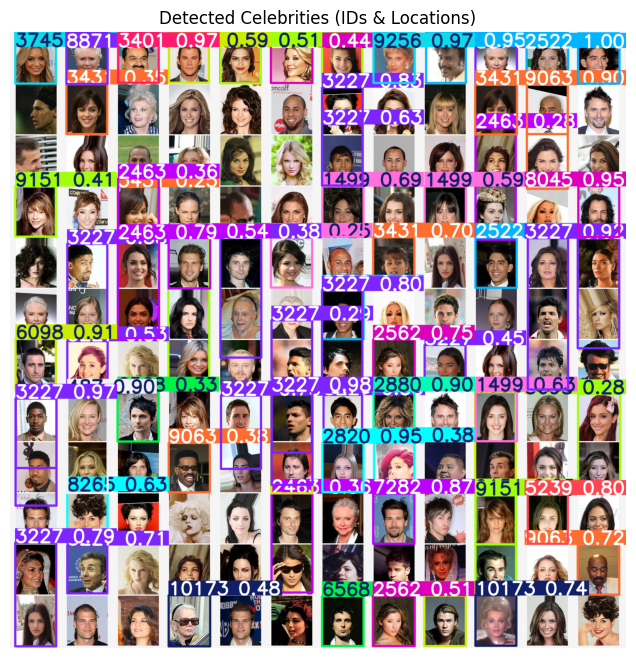


Predictions:
  ID: 2522 | Conf: 1.00 | Box: (1888, 4, 2026, 171)
  ID: 3227 | Conf: 0.98 | Box: (869, 1194, 1005, 1505)
  ID: 3401 | Conf: 0.97 | Box: (359, 1, 494, 168)
  ID: 3227 | Conf: 0.97 | Box: (18, 1218, 154, 1574)
  ID: 9256 | Conf: 0.97 | Box: (1208, 2, 1345, 169)
  ID: 2820 | Conf: 0.95 | Box: (1038, 1366, 1175, 1529)
  ID: 7904 | Conf: 0.95 | Box: (1383, 0, 1515, 169)
  ID: 8045 | Conf: 0.95 | Box: (1889, 512, 2025, 681)
  ID: 3227 | Conf: 0.92 | Box: (1721, 685, 1855, 1188)
  ID: 6098 | Conf: 0.91 | Box: (18, 1020, 152, 1190)
  ID: 2880 | Conf: 0.90 | Box: (1208, 1194, 1344, 1358)
  ID: 487 | Conf: 0.90 | Box: (190, 1201, 324, 1532)
  ID: 9063 | Conf: 0.90 | Box: (1718, 175, 1854, 339)
  ID: 7282 | Conf: 0.87 | Box: (1207, 1534, 1344, 1701)
  ID: 3227 | Conf: 0.83 | Box: (1037, 184, 1172, 510)
  ID: 5239 | Conf: 0.80 | Box: (1721, 1538, 1854, 1701)
  ID: 3227 | Conf: 0.80 | Box: (1037, 860, 1171, 1190)
  ID: 9151 | Conf: 0.80 | Box: (1547, 1540, 1681, 1703)
  ID: 3227 | C

In [ ]:
# --- Simple Object Detection Demo ---
from ultralytics import YOLO
import yaml
import matplotlib.pyplot as plt
from google.colab import files

# Load model and label info
COMP_ROOT = "/content/drive/MyDrive/celeba_dataset/CompositeDataset"
MODEL_PATH = f"{COMP_ROOT}/runs/yolov8n_grid4x4/weights/best.pt"
DATA_YAML = f"{COMP_ROOT}/data.yaml"

model = YOLO(MODEL_PATH)
with open(DATA_YAML, "r") as f:
    names = yaml.safe_load(f)["names"]

# Upload input image (professor gives in class)
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Run detection
res = model(img_path, conf=0.25, imgsz=1024)[0]

# Display result with bounding boxes
annotated = res.plot()
plt.figure(figsize=(8,8))
plt.imshow(annotated[..., ::-1])
plt.axis("off")
plt.title("Detected Celebrities (IDs & Locations)")
plt.show()

# Print detections (ID, confidence, box)
print("\nPredictions:")
for i, cid in enumerate(res.boxes.cls.cpu().numpy().astype(int)):
    conf = float(res.boxes.conf[i])
    x1, y1, x2, y2 = res.boxes.xyxy[i].cpu().numpy()
    print(f"  ID: {names[cid]} | Conf: {conf:.2f} | Box: ({int(x1)}, {int(y1)}, {int(x2)}, {int(y2)})")
